In [2]:
import numpy as np
from qutip import *
import dask
from dask import delayed
import dask.bag as db
from dask.distributed import Client, LocalCluster,progress
from tqdm import tqdm
import pandas as pd
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
# figure_features()

In [10]:
# create a matrix of dimension N x N with a value -1 in the second diagonal and 1 in the minus first diagonal and 0 elsewhere and obtained not as a np.array
def sinphi_op(N):
    return Qobj(-np.diag(np.ones(2*N),-1) + np.diag(np.ones(2*N),1))/2/1j

def cosphi_op(phi_ext,N):
    return Qobj(np.diag(np.ones(2*N),-1)*np.exp(1j*phi_ext) + np.diag(np.ones(2*N),1)*np.exp(-1j*phi_ext))/2

In [122]:
def eigensystem_fbq_odd(Ec,Eo,El,e_SO,phi_ext, N = 100, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 
    phi_ZPF=(8.0 * Ec / El) ** 0.25
    N_op  = 1j * (destroy(N).dag() - destroy(N)) / phi_ZPF /np.sqrt(2)
    phi_op= (destroy(N).dag() + destroy(N)) * phi_ZPF/ np.sqrt(2)

    # n_zpf = (Ej/32/Ec)**0.25
    # phi_ZPF = (2 * Ec / Ej) ** 0.25

    # N_op  = 1j *n_zpf * (destroy(N).dag() - destroy(N))
    # phi_op= phi_ZPF * (destroy(N).dag() + destroy(N))
    delta = phi_op - phi_ext

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor(N_op**2,qeye(2)) + 0.5*El*tensor(delta**2,qeye(2)) + Eo*tensor(phi_op.cosm(),qeye(2)) - e_z*tensor(phi_op.sinm(),sigmaz())
    evals,ekets=H.eigenstates(eigvals=eigvals)
    return evals,ekets

In [86]:
def eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = 8, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor(charge(N,-N)**2, qeye(2)) + Ej*tensor(qeye(2*N + 1) - cosphi_op(phi_ext,N),qeye(2)) + Eo*tensor(cosphi_op(0,N),qeye(2)) - e_z*tensor(sinphi_op(N),sigmaz()) - e_x*tensor(cosphi_op(0,N),sigmax()) - e_y*tensor(cosphi_op(0,N),sigmay())

    evals,ekets =H.eigenstates(eigvals=eigvals)
    mat_elem = 8*Ec*tensor(charge(N,-N), qeye(2)).matrix_element(ekets[1],ekets[0]) 
    return evals,ekets,mat_elem

100%|██████████| 4/4 [00:13<00:00,  3.41s/it]


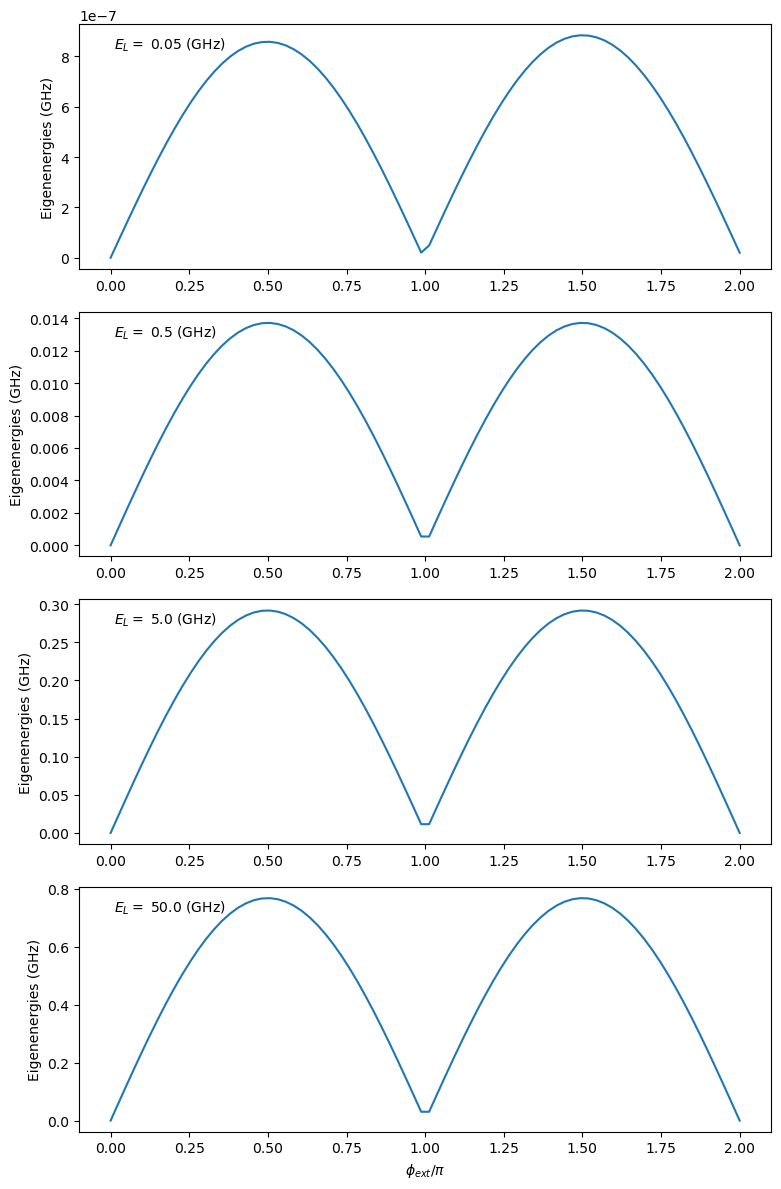

In [145]:
# plot the eigenvalues  of the function above
Ec = 20e9
Eo = 0.190e9
El = 0.05e9
e_SO = [0, 0, 0.600e9]
eigvals = 2

phi_ext_list = np.linspace(0,2*np.pi,80)
evals_list_charge = np.zeros((len(phi_ext_list),eigvals))
evals_list_fock = np.zeros((len(phi_ext_list),eigvals))
ekets_list = []
El_list = 5*np.logspace(7,10,4)

fig,ax = plt.subplots(len(El_list),1,figsize=(8,12))

for j,El in enumerate(tqdm(El_list)):
    for i, phi_ext in enumerate(phi_ext_list):
        evals_f,ekets_f = eigensystem_fbq_odd(Ec,Eo,El,e_SO,phi_ext, N = 100, eigvals = eigvals)
        evals_list_fock[i,:] = np.real(evals_f) 
    
    ax[j].plot(phi_ext_list/np.pi,(evals_list_fock[:,1] - evals_list_fock[:,0])/1e9)
    ax[j].set_ylabel('Eigenenergies (GHz)')
    ax[j].text(0.05,0.9,r'$E_L =$ {} (GHz)'.format(El*1e-9),transform=ax[j].transAxes)

ax[-1].set_xlabel(r'$\phi_{ext} /\pi$')    

plt.tight_layout()
plt.show()

In [110]:
Ec = 0.284e9
Eo = 0.190e9
Ej = 12.5e9
e_SO = [0.1e9, 0, 0.300e9]
eigvals = 4

phi_ext_list = np.linspace(0,3*np.pi,100)
evals_list_charge = np.zeros((len(phi_ext_list),eigvals))
ekets_list = []
mat_elem_list = np.zeros(len(phi_ext_list))

for i, phi_ext in enumerate(phi_ext_list):
    evals,ekets,mat_elem = eigensystem_gatemon_odd(Ec,Eo,Ej,e_SO,phi_ext, N = 3, eigvals = eigvals)
    evals_list_charge[i,:] = np.real(evals) 
    mat_elem_list[i] = np.abs(mat_elem)

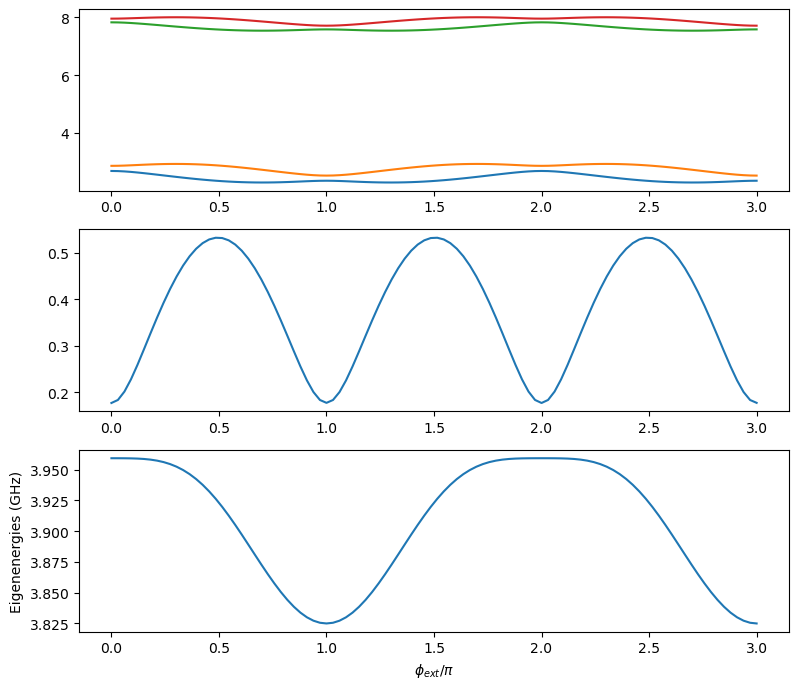

In [111]:
fig,ax = plt.subplots(3,1,figsize=(8,7))

# ax.plot(phi_ext_list/np.pi,(evals_list_fock[:,1]-evals_list_fock[:,0])/1e9)
ax[0].plot(phi_ext_list/np.pi,(evals_list_charge[:,:])/1e9)
ax[1].plot(phi_ext_list/np.pi,(evals_list_charge[:,1]-evals_list_charge[:,0])/1e9)
ax[2].plot(phi_ext_list/np.pi,mat_elem_list/1e6)
# ax[1].plot(phi_ext_list/np.pi,(evals_list_fock[:,3]-evals_list_fock[:,1])/1e9)
ax[2].set_ylabel('Eigenenergies (GHz)')

ax[2].set_xlabel(r'$\phi_{ext} /\pi$')
plt.tight_layout()
plt.show()

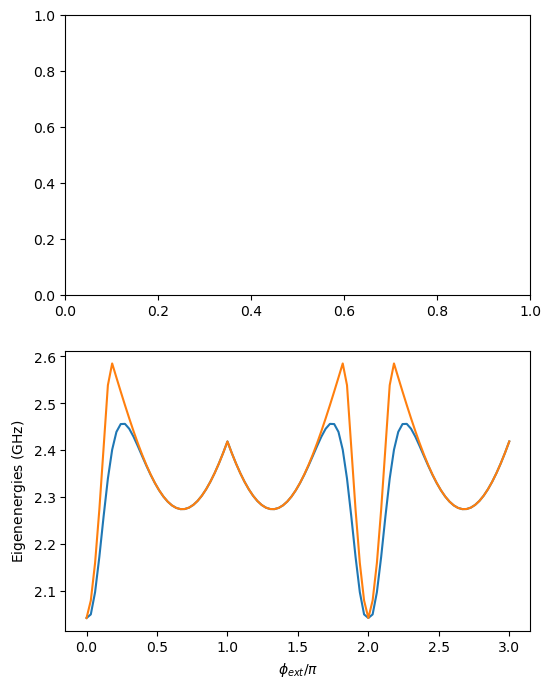

In [219]:
fig,ax = plt.subplots(2,1,figsize=(6,8))
# for i in range(eigvals):
#     ax[0].plot(phi_ext_list/np.pi,evals_list[:,i]/1e9)

# ax[0].plot(phi_ext_list/np.pi,(evals_list_charge[:,:])/1e9)
ax[1].plot(phi_ext_list/np.pi,(evals_list_fock[:,:2])/1e9)
ax[1].set_xlabel(r'$\phi_{ext}/\pi$')
ax[1].set_ylabel(r'Eigenenergies $\mathrm{(GHz)}$')

plt.show()